In [3]:
import io
import trimesh
import numpy as np
from PIL import Image
from os import listdir
import h5py
import json
import random
from os.path import isfile, join
from functools import reduce
import collections
import os
import glob
import argparse


def unproject_pixels(depth, cam_matrix, fx, fy):
    '''
    pts: [N, 2] pixel coords
    depth: [N, ] depth values
    returns: [N, 3] world coords
    '''
    mask = np.ones(depth.shape[:2], dtype=bool)
    pts = np.array([[x,y] for x,y in zip(np.nonzero(mask)[0], np.nonzero(mask)[1])])
    camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

    # Different from real-world camera coordinate system.
    # OpenGL uses negative z axis as the camera front direction.
    # x axes are same, hence y axis is reversed as well.
    # Source: https://learnopengl.com/Getting-started/Camera
    rot = np.array([[1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1]])
    camera_matrix = np.dot(camera_matrix, rot)


    height = depth.shape[0]
    width = depth.shape[1]

    img_pixs = pts[:, [1, 0]].T
    img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    intrinsics = np.array([[fx, 0, width/ 2.0],
                           [0, fy, height / 2.0],
                           [0, 0, 1]])
    img_inv = np.linalg.inv(intrinsics[:3, :3])
    cam_img_mat = np.dot(img_inv, img_pix_ones)

    points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
    points_in_cam = np.concatenate((points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0)
    points_in_world = np.dot(camera_matrix, points_in_cam)
    points_in_world = points_in_world[:3, :].T#.reshape(3, height, width)
    
    return points_in_world


scenario = 'dominoes'
source_path = '/home/haoliangwang/data/physion/'

vfov = 54.43222 
near_plane = 0.1
far_plane = 100

scenario_path = join(source_path, scenario+'_all_movies')
onlyhdf5 = ['pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0003.hdf5']
for hdf5_file in onlyhdf5:
    trial_name = '_'.join(hdf5_file.split('/')[-2:])[:-5]
    if trial_name.endswith('temp'):
        continue
    print('\t', trial_name)

    hdf5_file_path = join(scenario_path, hdf5_file)

    depth_arr = []
    image_arr = []
    with h5py.File(hdf5_file_path, "r") as f:
        # extract depth info
        for key in f['frames'].keys():
            depth = np.array(f['frames'][key]['images']['_depth_cam0'])
            depth_arr.append(depth)
            image = np.array(Image.open(io.BytesIO(f['frames'][key]['images']['_img_cam0'][:])))
            image_arr.append(image)
        depth_arr = np.asarray(depth_arr)
        image_arr = np.asarray(image_arr)
        height, width = image_arr.shape[1], image_arr.shape[2]

        # extract camera info
        camera_matrix = np.array(f['frames']['0000']['camera_matrices']['camera_matrix_cam0']).reshape((4, 4))

        # Calculate the intrinsic matrix from vertical_fov.
        # Motice that hfov and vfov are different if height != width
        # We can also get the intrinsic matrix from opengl's perspective matrix.
        # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
        vfov = vfov / 180.0 * np.pi
        tan_half_vfov = np.tan(vfov / 2.0)
        tan_half_hfov = tan_half_vfov * width / float(height)
        fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
        fy = height / 2.0 / tan_half_vfov

    frame = 0
    pc = unproject_pixels(depth_arr[frame], camera_matrix, fx, fy)
    pc[:,[2,1]] = pc[:,[1,2]]
    non_flat = pc.reshape(width, height, 3)
    rgb_pc = np.concatenate([image_arr[frame], non_flat], axis=-1)


	 pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0003


In [4]:
old = rgb_pc
old

array([[[ 2.90000000e+01,  4.10000000e+01,  5.60000000e+01,
          3.70390204e+00, -2.39627599e+00, -1.81683105e-02],
        [ 3.20000000e+01,  4.50000000e+01,  6.40000000e+01,
          3.69937044e+00, -2.39814576e+00, -1.81683103e-02],
        [ 8.10000000e+01,  1.01000000e+02,  1.24000000e+02,
          3.69483885e+00, -2.40001554e+00, -1.81683101e-02],
        ...,
        [ 1.52000000e+02,  1.57000000e+02,  1.73000000e+02,
         -9.04118641e-01, -3.94638914e+00,  8.01364708e-02],
        [ 1.51000000e+02,  1.56000000e+02,  1.71000000e+02,
         -9.08277030e-01, -3.94638560e+00,  8.06177346e-02],
        [ 1.49000000e+02,  1.54000000e+02,  1.69000000e+02,
         -9.12431914e-01, -3.94636674e+00,  8.11028833e-02]],

       [[ 2.90000000e+01,  4.00000000e+01,  5.40000000e+01,
          3.69416409e+00, -2.38552110e+00, -1.85792160e-02],
        [ 7.80000000e+01,  9.40000000e+01,  1.12000000e+02,
          3.68964133e+00, -2.38738722e+00, -1.85792158e-02],
        [ 6.40000

In [5]:
np.save('/home/haoliangwang/uncos/haoliang/test/test_dominoes.npy', rgb_pc)

In [4]:
saved = np.load('/home/haoliangwang/uncos/haoliang/test/pilot_dominoes_2mid_J025R30_tdwroom_0025.npy')

In [5]:
(saved==old).all()

True

In [1]:
import io
import trimesh
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import json
import random
from copy import deepcopy
import itertools
from tqdm import tqdm
from functools import reduce
import collections
import os
import glob
import argparse
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
hdf5_file_path = '/home/haoliangwang/data/physion/dominoes_all_movies/pilot_dominoes_default_boxroom_0020.hdf5'

In [3]:
vfov = 54.43222 
near_plane = 0.1
far_plane = 100
depth_arr = []
image_arr = []
base_id, base_type, attachment_id, attachent_type, attachment_fixed, use_attachment, use_base, use_cap, cap_id = None, None, None, None, None, None, None, None, None
with h5py.File(hdf5_file_path, "r") as f:
    # extract depth info
    for key in f['frames'].keys():
        depth = np.array(f['frames'][key]['images']['_depth_cam0'])
        depth_arr.append(depth)
        image = np.array(Image.open(io.BytesIO(f['frames'][key]['images']['_img_cam0'][:])))
        image_arr.append(image)
    depth_arr = np.asarray(depth_arr)
    image_arr = np.asarray(image_arr)
    FINAL_T, height, width = image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]

    # extract camera info
    camera_azimuth = np.array(f['azimuth']['cam_0'])
    camera_matrix = np.array(f['frames']['0000']['camera_matrices']['camera_matrix_cam0']).reshape((4, 4))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
    fy = height / 2.0 / tan_half_vfov


In [4]:
frame = 0

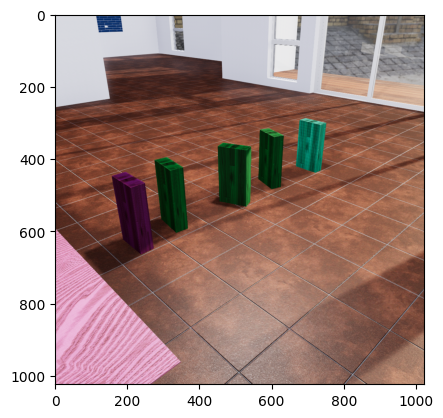

In [5]:
plt.imshow(image_arr[frame])

In [6]:
im = Image.fromarray(image_arr[frame])
im.save("/home/haoliangwang/sam2/pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0002.png")

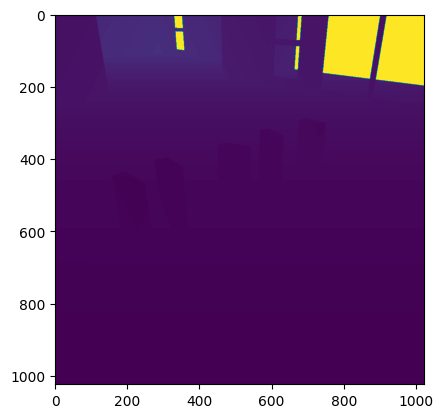

In [6]:
plt.imshow(depth_arr[frame])

# using open3d

In [35]:
# intrinsics = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, width/ 2.0, height / 2.0)
# pcd = o3d.geometry.PointCloud.create_from_depth_image(o3d.geometry.Image(depth_arr[frame]), intrinsics)
# pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
# o3d.visualization.draw_geometries([pcd])    # visualize the point cloud

In [36]:
# xyz = np.asarray(pcd.points)

In [37]:
# xyz.shape

In [38]:
# xyz[:,[2,1]] = xyz[:,[1,2]]
# xyz.shape

In [39]:
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(xyz)
# o3d.visualization.draw_geometries([pcd])  

In [40]:
# rgb_pc = np.concatenate([image_arr[frame], xyz], axis=-1)

In [41]:
# rgb_pc.shape

In [42]:
# np.save('/home/haoliangwang/uncos/haoliang/test.npy', rgb_pc)

# using my own method

In [7]:
def unproject_pixels(depth, cam_matrix, fx, fy):
    '''
    pts: [N, 2] pixel coords
    depth: [N, ] depth values
    returns: [N, 3] world coords
    '''
    mask = np.ones(depth.shape[:2], dtype=bool)
    pts = np.array([[x,y] for x,y in zip(np.nonzero(mask)[0], np.nonzero(mask)[1])])
    camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

    # Different from real-world camera coordinate system.
    # OpenGL uses negative z axis as the camera front direction.
    # x axes are same, hence y axis is reversed as well.
    # Source: https://learnopengl.com/Getting-started/Camera
    rot = np.array([[1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1]])
    camera_matrix = np.dot(camera_matrix, rot)


    height = depth.shape[0]
    width = depth.shape[1]

    img_pixs = pts[:, [1, 0]].T
    img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    intrinsics = np.array([[fx, 0, width/ 2.0],
                           [0, fy, height / 2.0],
                           [0, 0, 1]])
    img_inv = np.linalg.inv(intrinsics[:3, :3])
    cam_img_mat = np.dot(img_inv, img_pix_ones)

    points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
    points_in_cam = np.concatenate((points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0)
    points_in_world = np.dot(camera_matrix, points_in_cam)
    points_in_world = points_in_world[:3, :].T#.reshape(3, height, width)
    
    return points_in_world


In [8]:
pc = unproject_pixels(depth_arr[frame], camera_matrix, fx, fy)

In [10]:
pc[:,[2,1]] = pc[:,[1,2]]
pc.shape

(1048576, 3)

In [11]:
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(pc)
# o3d.visualization.draw_geometries([pcd])    # visualize the point cloud

In [12]:
# xyz = np.asarray(pcd.points)
non_flat = pc.reshape(width, height, 3)
non_flat.shape

(1024, 1024, 3)

In [13]:
rgb_pc = np.concatenate([image_arr[frame], non_flat], axis=-1)

In [14]:
rgb_pc.shape

(1024, 1024, 6)

In [17]:
np.save('/home/haoliangwang/uncos/haoliang/test/pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0002.npy', rgb_pc)

In [19]:
saved = np.load('/home/haoliangwang/uncos/haoliang/test/pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0001.npy')

In [20]:
(rgb_pc==saved).all()

False

In [21]:
rgb_pc

array([[[ 7.70000000e+01,  1.00000000e+02,  1.18000000e+02,
          5.49457409e+00, -2.98288044e-01, -2.38695443e-02],
        [ 7.30000000e+01,  9.50000000e+01,  1.13000000e+02,
          5.49108254e+00, -3.03032999e-01, -2.38695441e-02],
        [ 8.00000000e+01,  1.02000000e+02,  1.20000000e+02,
          5.48759098e+00, -3.07777955e-01, -2.38695438e-02],
        ...,
        [ 1.50000000e+02,  1.52000000e+02,  1.70000000e+02,
          1.27597299e+00, -3.94101515e+00,  2.85670769e-01],
        [ 1.55000000e+02,  1.57000000e+02,  1.75000000e+02,
          1.27107531e+00, -3.94100645e+00,  2.86657698e-01],
        [ 1.48000000e+02,  1.50000000e+02,  1.67000000e+02,
          1.26617536e+00, -3.94097975e+00,  2.87647747e-01]],

       [[ 9.30000000e+01,  1.16000000e+02,  1.35000000e+02,
          5.46992658e+00, -2.91766433e-01, -2.33267954e-02],
        [ 8.00000000e+01,  1.00000000e+02,  1.15000000e+02,
          5.46644585e+00, -2.96496672e-01, -2.33267952e-02],
        [ 8.80000

In [24]:
saved

array([[[ 77.        , 100.        , 118.        ,   2.10523996,
          -1.54913172,  -2.29179988],
        [ 73.        ,  95.        , 113.        ,   2.10523996,
          -1.54913172,  -2.29179988],
        [ 80.        , 102.        , 120.        ,   2.10523996,
          -1.54913172,  -2.29179988],
        ...,
        [150.        , 152.        , 170.        ,   1.41752691,
          -1.04308113,  -1.5431439 ],
        [155.        , 157.        , 175.        ,   1.41533423,
          -1.04146766,  -1.54075691],
        [148.        , 150.        , 167.        ,   1.41313461,
          -1.03984908,  -1.53836237]],

       [[ 93.        , 116.        , 135.        ,   2.0942234 ,
          -1.54102524,  -2.27980707],
        [ 80.        , 100.        , 115.        ,   2.0942234 ,
          -1.54102524,  -2.27980707],
        [ 88.        , 112.        , 130.        ,   2.0942234 ,
          -1.54102524,  -2.27980707],
        ...,
        [144.        , 148.        , 163.    

# Xiaolin's data

In [31]:
xiaolin = np.load('/Users/haoliangwang/code/physion/franka_000.npy')

In [32]:
rgb_image, xyz = xiaolin[..., :3].astype(np.uint8).copy(), xiaolin[..., 3:].copy()

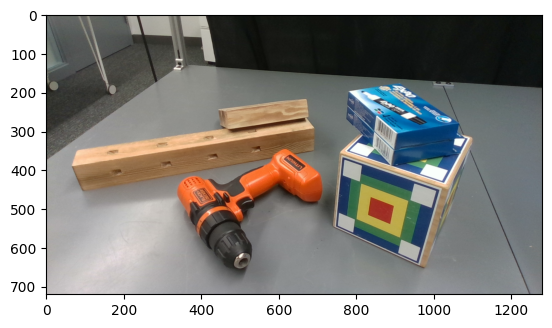

In [33]:
plt.imshow(rgb_image)

In [34]:
xyz.shape

(720, 1280, 3)

In [35]:
xyz_flat = xyz.reshape(-1, xyz.shape[-1])
xyz_flat.shape

(921600, 3)

In [36]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_flat)
o3d.visualization.draw_geometries([pcd])    # visualize the point cloud

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [38]:
xyz_flat[:,[0,1]] = xyz_flat[:,[1,0]]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_flat)
o3d.visualization.draw_geometries([pcd])    # visualize the point cloud

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [10]:
xyz_nonflat = xyz_flat.reshape(xyz.shape)
xyz_nonflat.shape


(720, 1280, 3)

In [12]:
rgb_pc = np.concatenate([rgb_image, xyz_nonflat], axis=-1)
rgb_pc.shape

(720, 1280, 6)

In [13]:
np.save('/Users/haoliangwang/Desktop/test.npy', rgb_pc)